# Convert CZI to PNGs

Convert the CZI file copied over in the prior step into a series of PNGs that can be segmented and otherwise easily processed. 

In [1]:
from pathlib import Path
import types
import multiprocessing

import numpy as np
import pandas as pd
import skimage.io
import skimage.exposure
import matplotlib.pyplot as plt
from tqdm import tqdm
import cloudpickle

import aicspylibczi

The magic functions that set our defaults, or load them from the calling `datastep` instance.

In [2]:
# Try to load step config, use defaults if not found
config_path = Path('config.pkl')
if config_path.exists():
    with open(config_path, 'rb') as file:
        config = cloudpickle.load(file)
else:
    config = types.SimpleNamespace()
    config.interactive = True
    config.step_local_staging_dir = Path('local_staging/mov2img')
    config.direct_upstream_tasks = ['null2mov']
    
# Find (and create if necessary) input and output dirs
local_staging = ('../../..' / config.step_local_staging_dir).resolve()
img_output_dir = local_staging / 'imgs'
img_output_dir.mkdir(parents=True, exist_ok=True)
input_dir = (local_staging / '../null2mov/mov').resolve()

That gives us where we're going to write our files to and where we're going to get them from, but we need to know exactly what time lapses we are dealing with and what sections of them we want to extract. There is no way to automatically determine this so I'm setting it manually on a per file basis.

In [3]:
input_czis = ('20170711_I01_001.czi', )
# Input regions are X,Y,W,H, but the XY offsets are crazy for unknown reasons
input_regions = (((86858, 37925, 2356, 2356), 
                  (86858+6443, 37925+6596, 2356, 2356)
                 ), )
input_channels = 3 

Now we'll make some support functions for loading, processing, and saving individual frames from our input czis. They will do a few things, take a czi and load the z-slice at on a given channel at a given time for a given region of a mosaic. Then take the max project across the z-slices and return a 2d array.

The output function does some exposure correction to minimize signal loss.

In [4]:
def read_frame(czi, time, region, channel, z_slices):
    """Read mosaic segment to np.array"""
    # Creating holding stack
    width, height = region[-2], region[-1]
    img_stack = np.ones((z_slices, width, height))
    # Read slices
    for z in range(z_slices):
        img = czi.read_mosaic(Z=z, C=channel, T=time,
                              scale_factor=1.0, region=region)
        img_stack[z] = img.squeeze().astype(np.uint32)
    return img_stack.max(0) 

def convert_frame(img):
    """Convert our input image to a contrast enhanced 8bit image"""
    img = img.squeeze().astype(np.float)
    img = np.swapaxes(img, 0, -1)
    img = skimage.exposure.rescale_intensity(img, out_range=np.uint8)
    img = img.astype(np.uint8)
    return img

def write_frame(img, out_dir, name, mosaic_index, channel, time):
    """Write frame to png with standard name format"""
    name = name if not name.endswith('.czi') else name[:-4]
    out_name = f"{name}_M{mosaic_index}_C{channel}_T{time:02}.png"
    skimage.io.imsave(out_dir / out_name, img, check_contrast=False)
    return out_name

def frame_pipeline(params):
    czi = aicspylibczi.CziFile(params['input_dir'] / params['czi_fn'])
    img = read_frame(czi, params['time'], params['region'], params['channel'], params['z_slices'])
    img = convert_frame(img)
    fn_out = write_frame(img, params['out_dir'], params['czi_fn'], params['region_i'], params['channel'], params['time']) 
    path_out = str(config.step_local_staging_dir)+'/imgs/'
    out_log = dict(filepath=path_out+fn_out,
                   original_czi=params['czi_fn'],
                   channel=params['channel'],
                   time=params['time'], 
                   region=params['region_i'])
    return out_log

Let's take a look at the channels of one of our mosaics for the first time step.

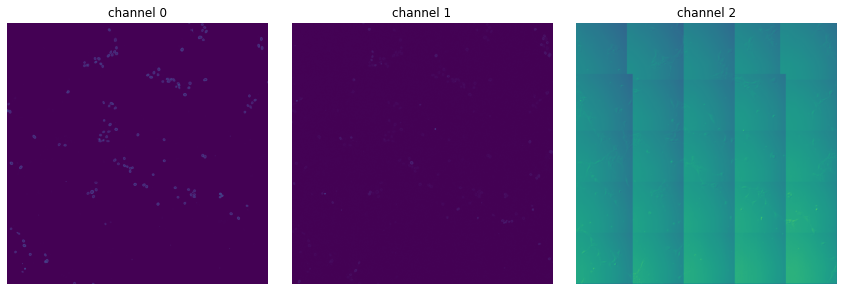

In [5]:
czi = aicspylibczi.CziFile(input_dir/input_czis[0])
z_slices = czi.dims_shape()[0]['Z'][1]

fig, axs = plt.subplots(1, input_channels, figsize=(12,4))
for channel, ax in enumerate(axs):
    img = read_frame(czi, 0, input_regions[0][0], channel, z_slices)
    img = convert_frame(img)
    ax.imshow(img)
    ax.axis('off')
    ax.set(title=f"channel {channel}")
plt.tight_layout()

While faint, those channels have a clear signal. Let's walk through all frames. First we'll create a set of parameters we'll run through the frame pipeline above.

In [6]:
param_sets = []

for czi_i, czi_fn in enumerate(input_czis):
    czi = aicspylibczi.CziFile(input_dir / czi_fn)
    dims = czi.dims_shape()[0]
    z_slices = dims['Z'][1]
    channels = dims['C'][1]
    if config.interactive:
        times = 1
    else:
        times = dims['T'][1]
    for region_i, region in enumerate(input_regions[czi_i]):
        for channel in range(channels):
            for time in range(times):
                param_sets.append(dict(
                    input_dir = input_dir, 
                    czi_fn = czi_fn, 
                    time = time, 
                    region = region, 
                    region_i = region_i, 
                    channel = channel, 
                    z_slices = z_slices, 
                    out_dir = img_output_dir
                    ))
                
pd.DataFrame(param_sets).head(3)

,input_dir,czi_fn,time,region,region_i,channel,z_slices,out_dir
0,/allen/aics/modeling/cdave/repos/workflow_colo...,20170711_I01_001.czi,0,"(86858, 37925, 2356, 2356)",0,0,3,/allen/aics/modeling/cdave/repos/workflow_colo...
1,/allen/aics/modeling/cdave/repos/workflow_colo...,20170711_I01_001.czi,0,"(86858, 37925, 2356, 2356)",0,1,3,/allen/aics/modeling/cdave/repos/workflow_colo...
2,/allen/aics/modeling/cdave/repos/workflow_colo...,20170711_I01_001.czi,0,"(86858, 37925, 2356, 2356)",0,2,3,/allen/aics/modeling/cdave/repos/workflow_colo...


And then distribute them to the cores of this machine. 

In [7]:
with multiprocessing.Pool(multiprocessing.cpu_count()) as pool:
    manifest = pool.map(frame_pipeline, param_sets)

config.manifest = pd.DataFrame(manifest)
config.metadata_columns = ['original_czi', 'channel', 'time', 'region']

That is all the CZI frames written out in an accessible format.

In [8]:
config.manifest

,filepath,original_czi,channel,time,region
0,imgs/20170711_I01_001_M0_C0_T00.png,20170711_I01_001.czi,0,0,0
1,imgs/20170711_I01_001_M0_C1_T00.png,20170711_I01_001.czi,1,0,0
2,imgs/20170711_I01_001_M0_C2_T00.png,20170711_I01_001.czi,2,0,0
3,imgs/20170711_I01_001_M1_C0_T00.png,20170711_I01_001.czi,0,0,1
4,imgs/20170711_I01_001_M1_C1_T00.png,20170711_I01_001.czi,1,0,1
5,imgs/20170711_I01_001_M1_C2_T00.png,20170711_I01_001.czi,2,0,1


And finally, if this was called from a step, write the configuration back out. 

In [ ]:
if config_path.exists():
    with open(config_path, 'wb') as file:
        cloudpickle.dump(config, file)